# Clasificacion de sentimientos

## Conjunto de datos

Este es un conjunto de datos de 11.228 noticias de Reuters, etiquetadas en 46 temas.

Cada noticia está codificado como una lista de índices de palabras (números enteros). Para mayor comodidad, las palabras se indexan por la frecuencia general en el conjunto de datos, de modo que, por ejemplo, el número entero "3" codifica la tercera palabra más frecuente en los datos. Esto permite realizar operaciones de filtrado rápido como: "considerar sólo las 10.000 palabras más comunes, pero eliminar las 20 palabras más comunes".

## 1. Cargando el conjunto de datos

In [2]:
from tensorflow.keras.datasets import reuters
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow import keras
import IPython
import tensorflow as tf

In [3]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

El argumento num_words indica que únicamente tendremos en cuenta las 10.000 palabras más frecuentes del conjunto de datos. Por lo tanto, el resto de palabras que sean poco frecuentes, serán descartadas y no formarán parte de las reseñas con las que entrenaremos y probaremos el algoritmo.

In [4]:
# Índices de las palabras
word_index = reuters.get_word_index()
word_index

{'mdbl': 10996,
 'fawc': 16260,
 'degussa': 12089,
 'woods': 8803,
 'hanging': 13796,
 'localized': 20672,
 'sation': 20673,
 'chanthaburi': 20675,
 'refunding': 10997,
 'hermann': 8804,
 'passsengers': 20676,
 'stipulate': 20677,
 'heublein': 8352,
 'screaming': 20713,
 'tcby': 16261,
 'four': 185,
 'grains': 1642,
 'broiler': 20680,
 'wooden': 12090,
 'wednesday': 1220,
 'highveld': 13797,
 'duffour': 7593,
 '0053': 20681,
 'elections': 3914,
 '270': 2563,
 '271': 3551,
 '272': 5113,
 '273': 3552,
 '274': 3400,
 'rudman': 7975,
 '276': 3401,
 '277': 3478,
 '278': 3632,
 '279': 4309,
 'dormancy': 9381,
 'errors': 7247,
 'deferred': 3086,
 'sptnd': 20683,
 'cooking': 8805,
 'stratabit': 20684,
 'designing': 16262,
 'metalurgicos': 20685,
 'databank': 13798,
 '300er': 20686,
 'shocks': 20687,
 'nawg': 7972,
 'tnta': 20688,
 'perforations': 20689,
 'affiliates': 2891,
 '27p': 20690,
 'ching': 16263,
 'china': 595,
 'wagyu': 16264,
 'affiliated': 3189,
 'chino': 16265,
 'chinh': 16266,
 '

In [5]:
print("Trainning data:", len(train_data))
print("Testing data:", len(test_data))

Trainning data: 8982
Testing data: 2246


In [6]:
# Primer artículo del conjunto de datos de entrenamiento
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [7]:
reversed_word_index = {v: k for k, v in word_index.items()}
' '.join([reversed_word_index.get(i - 3, '(' + str(i) + ')') for i in train_data[0]])

'(1) (2) (2) said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

Las variables _train_labels_ y _test_labels_ se corresponden con una lista de valores que se encuentran en la siguiente lista (*):
```
"reuters":
  ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead'],
```

In [8]:
train_labels

array([ 3,  4,  3, ..., 25,  3, 25], dtype=int64)

## Preprocesamiento del conjunto de datos

A pesar de que ya tenemos codificadas las reseñas para que esten representadas por valores numéricos en lugar de por cadenas de texto, existen algunos factores que no permiten que sean conjuntos de datos apropiados para proporcionarle a una red neuronal artifical.

In [9]:
def vectorize(seqs, dim=10000):
    results = np.zeros((len(seqs), dim))
    for i, seq in enumerate(seqs):
        results[i, seq] = 1.
    return results

Vectorizamos tanto el conjunto de datos de entrenamiento, como el conjunto de datos de pruebas.

In [10]:
# Vectorizamos el conjunto de datos de entrenamiento y el de pruebas
X_train = vectorize(train_data, 10000)
X_test = vectorize(test_data, 10000)

In [11]:
# Cada una de las reseñas se corresponde con un vector formado por 1s y 0s
print("Valores originales:\t", train_data[0][:15])
print("Valores vectorizados:\t", X_train[0][:15])

Valores originales:	 [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16]
Valores vectorizados:	 [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


In [12]:
# Transformamos las etiquetas de salida en vectores

Y_train = to_categorical(train_labels)
Y_test = to_categorical(test_labels)

In [13]:
train_labels[0]

3

In [14]:
Y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## División del conjunto de datos 

In [15]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

In [16]:
print("Longitud subconjunto de entrenamiento: ", len(X_train))
print("Longitud subconjunto de validación: ", len(X_val))
print("Longitud subconjunto de pruebas: ", len(X_test))

Longitud subconjunto de entrenamiento:  8982
Longitud subconjunto de validación:  1123
Longitud subconjunto de pruebas:  1123


## Construcción de la red neuronal artificial

In [17]:
def model_builder(hp):
    # Definición del modelo
    model = keras.Sequential()

    # Tuning del número de neuronas de las hidden layer
    hp_units = hp.Int('units', min_value=8, max_value=128, step=8)
    
    # Tuning del número de capas
    hp_layers = hp.Int('layers', min_value=1, max_value=5, step=1)
    
    # Input layer
    model.add(layers.Dense(units=128, activation='relu', input_shape=(10000,)))
    
    # Hidden layers 
    for i in range(hp_layers):
        # Añadimos la hidden layer
        model.add(layers.Dense(units=hp_units, activation='relu'))
        
    # Output layer
    model.add(layers.Dense(46, activation='softmax'))
    
    # Seleccionamos el valor optimo entre [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate), 
        loss='categorical_crossentropy',
        metrics=['accuracy', 'Precision']
    )
    
    return model

In [18]:
tuner = kt.Hyperband(
    model_builder,
    objective= 'val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hp_dir',
    project_name='ruters_dataset'
)

In [19]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [20]:
# Ejecución del proceso de tuning
tuner.search(
    X_train, 
    Y_train,
    epochs=10,
    validation_data=(X_val, Y_val),
    callbacks=[ClearTrainingOutput()]
)

Trial 30 Complete [00h 00m 26s]
val_accuracy: 0.7186108827590942

Best val_accuracy So Far: 0.7292965054512024
Total elapsed time: 00h 05m 06s
INFO:tensorflow:Oracle triggered exit


In [32]:
# Obtención de los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hps.get('units'))
print("Layers:", best_hps.get('layers'))

Units: 72
Layers: 2


In [33]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train,
    Y_train,
    epochs = 18,
    validation_data = (X_val, Y_val)
)

Epoch 1/18
281/281 [==============================] - 3s 7ms/step - loss: 2.6516 - accuracy: 0.4218 - precision: 0.9450 - val_loss: 1.9907 - val_accuracy: 0.5129 - val_precision: 0.9270
Epoch 2/18
281/281 [==============================] - 2s 6ms/step - loss: 1.8060 - accuracy: 0.5381 - precision: 0.9235 - val_loss: 1.7338 - val_accuracy: 0.5699 - val_precision: 0.9099
Epoch 3/18
281/281 [==============================] - 2s 6ms/step - loss: 1.6075 - accuracy: 0.6180 - precision: 0.9225 - val_loss: 1.6041 - val_accuracy: 0.6331 - val_precision: 0.9199
Epoch 4/18
281/281 [==============================] - 2s 6ms/step - loss: 1.4744 - accuracy: 0.6697 - precision: 0.9286 - val_loss: 1.5024 - val_accuracy: 0.6572 - val_precision: 0.9153
Epoch 5/18
281/281 [==============================] - 2s 6ms/step - loss: 1.3493 - accuracy: 0.6976 - precision: 0.9304 - val_loss: 1.4046 - val_accuracy: 0.6794 - val_precision: 0.9220
Epoch 6/18
281/281 [==============================] - 2s 6ms/step - lo

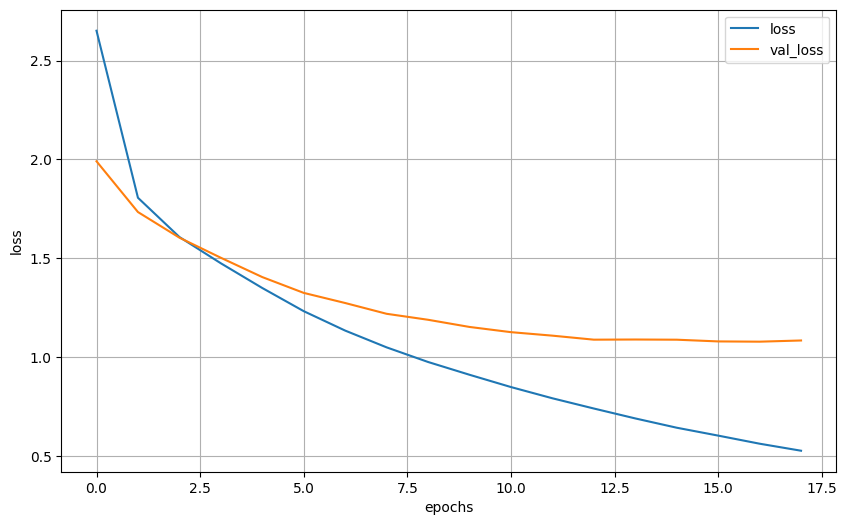

In [34]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

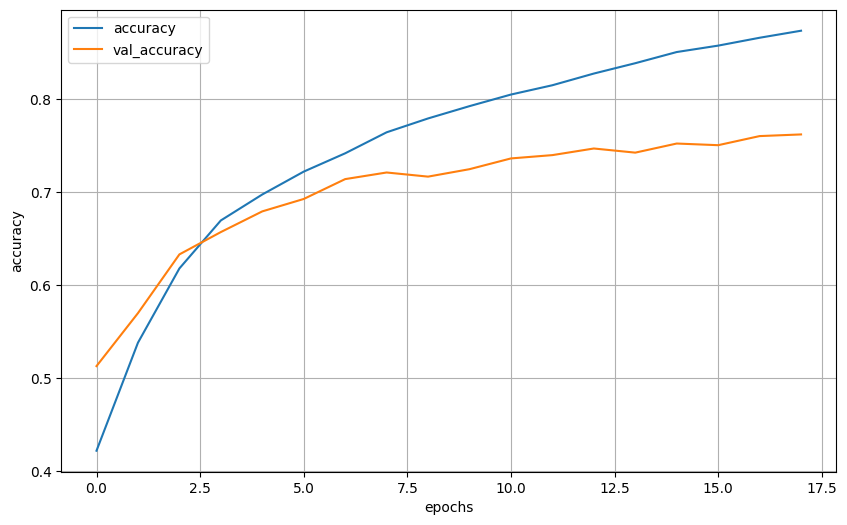

In [35]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [36]:
model.evaluate(X_test, Y_test)

36/36 [==============================] - 0s 3ms/step - loss: 1.0323 - accuracy: 0.7694 - precision: 0.8725


[1.0322916507720947, 0.7693677544593811, 0.8724831938743591]

In [37]:
model.predict(X_test).round(0)

36/36 [==============================] - 0s 2ms/step


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)